In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
# from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/rawdata.csv')

In [ ]:
raw_data

,날짜,현재수위,유입량,저수량,공용량,방류량,강화대교_조위,청담대교_유량,잠수교_유량,한강대교_유량,행주대교_유량,대곡교_강수량,진관교_강수량,송정동_강수량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,2012-05-01 00:00,24.800,555.00,219.07,24.93,555.00,445.0,469.05,0.0,729.80,540.18,0.0,0.0,0.0,310.7,300.2,290.0,275.3
1,2012-05-01 00:10,24.794,464.60,218.86,25.15,562.90,449.0,498.00,0.0,731.48,540.18,0.0,0.0,0.0,314.7,300.2,290.0,275.3
2,2012-05-01 00:20,24.789,478.10,218.69,25.31,576.40,451.0,490.68,0.0,726.42,540.18,0.0,0.0,0.0,313.7,301.2,290.0,275.3
3,2012-05-01 00:30,24.789,464.80,218.69,25.31,563.10,452.0,476.21,0.0,726.42,552.17,0.0,0.0,0.0,311.7,301.2,290.0,276.3
4,2012-05-01 00:40,24.789,478.10,218.69,25.31,576.40,450.0,476.21,0.0,707.17,564.29,0.0,0.0,0.0,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10,25.040,259.23,212.86,31.14,259.23,510.0,319.84,NaN,-456.41,974.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276332,2022-07-18 23:20,25.040,260.46,212.86,31.14,260.46,492.0,314.01,NaN,-717.30,1006.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276333,2022-07-18 23:30,25.040,259.37,212.86,31.14,259.37,475.0,387.55,NaN,-843.37,1039.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276334,2022-07-18 23:40,25.040,259.13,212.86,31.14,259.13,458.0,454.91,NaN,-1023.37,1073.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
raw_data = raw_data['행주대교_유량']

In [ ]:
nanIndex = raw_data[raw_data.isnull()==True].index

In [ ]:
nanIndex

Int64Index([140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620,
            140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628,
            140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636,
            140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644,
            140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652,
            140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660,
            140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668,
            140669, 140670, 236080],
           dtype='int64')

In [ ]:
consecutive = list(nanIndex)[:-1]
unconsecutive = list(nanIndex)[-1]
print(consecutive)
print(unconsecutive)

[140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620, 140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628, 140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636, 140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644, 140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652, 140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660, 140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668, 140669, 140670]
236080


In [ ]:
print(len(consecutive) + 1 == len(nanIndex) )

True


In [ ]:
# 58개 결측치 앞 인덱스까지 인풋 생성
x = raw_data.iloc[:140613]

In [ ]:
x

0          540.18
1          540.18
2          540.18
3          552.17
4          564.29
           ...   
140608    2385.34
140609    2410.83
140610    2359.99
140611    2359.99
140612    2410.83
Name: 행주대교_유량, Length: 140613, dtype: float64

In [ ]:
y_predict = []

xtrain = []
ytrain = []

w =  200 # window size
n = 58 # 예측할 데이터 개수

for i in tqdm(range(len(x)-w-n)):
    xtrain.append(np.array(x.iloc[i:i + w]).astype(float))
for i in tqdm(range(w, len(x)-n)):
  ytrain.append(np.array(x.iloc[i:i+n]).astype(float))

100%|██████████| 140355/140355 [00:05<00:00, 26265.27it/s]


In [ ]:
xtrain = np.array(xtrain).reshape(140355, 200, 1)
ytrain = np.array(ytrain).reshape(140355, 58,)

In [ ]:
def inverse_transform(y_test, yhat):
     y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
     yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
     yhat_inverse = scaler.inverse_transform(yhat_reshaped)
     y_test_inverse = scaler.inverse_transform(y_test_reshaped)
     return yhat_inverse, y_test_inverse

def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    rmse = np.sqrt(mae_(y_test_inverse,yhat_inverse))
    print('rmse:', rmse)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

In [ ]:
model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
model_enc_dec_cnn.add(AveragePooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(100, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(58))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

In [ ]:
model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 199, 8)            24        
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 16)           272       
                                                                 
 average_pooling1d (AverageP  (None, 99, 16)           0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 1584)              0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 1584)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               6

In [ ]:
# plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 256
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
439/439 [==============================] - 30s 63ms/step - loss: 450.6479 - accuracy: 0.0770 - val_loss: 259.9653 - val_accuracy: 0.0757 - lr: 0.0100
Epoch 2/100
439/439 [==============================] - 25s 57ms/step - loss: 385.3788 - accuracy: 0.1030 - val_loss: 238.5723 - val_accuracy: 0.1787 - lr: 0.0100
Epoch 3/100
439/439 [==============================] - 25s 56ms/step - loss: 363.9747 - accuracy: 0.1100 - val_loss: 204.6599 - val_accuracy: 0.1343 - lr: 0.0100
Epoch 4/100
439/439 [==============================] - 25s 57ms/step - loss: 354.5782 - accuracy: 0.1133 - val_loss: 204.0970 - val_accuracy: 0.1508 - lr: 0.0100
Epoch 5/100
439/439 [==============================] - 24s 56ms/step - loss: 339.0917 - accuracy: 0.1190 - val_loss: 207.0123 - val_accuracy: 0.1362 - lr: 0.0100
Epoch 6/100
439/439 [==============================] - 26s 59ms/step - loss: 327.4588 - accuracy: 0.1330 - val_loss: 203.3650 - val_accuracy: 0.1489 - lr: 0.0100
Epoch 7/100
439/439 [=======

In [ ]:
xtest = x[-200:]
xtest = np.array(xtest).reshape(1, 200, 1)

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

y_predict = keras_model_best.predict(xtest, verbose=1)

y_predict = y_predict[0]

1/1 [==============================] - 0s 229ms/step


In [ ]:
raw_data.iloc[consecutive] = y_predict

In [ ]:
# unconsecutive 부분 보간

unconsecutive2 = [unconsecutive-1, unconsecutive, unconsecutive+1]
raw_data.iloc[unconsecutive2] = raw_data.iloc[unconsecutive2].interpolate()

In [ ]:
raw_data.isnull().sum()

0

In [ ]:
raw_data.to_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/CNN_전처리/행주대교_유량_2nd.csv', index = False, encoding = 'cp949')

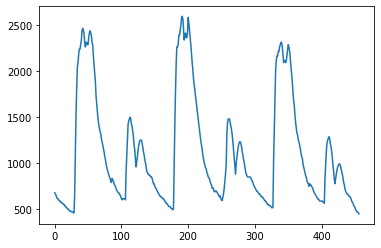

In [ ]:
start  = consecutive[0] -200
end = consecutive[-1] + 200

x1 = range(len(raw_data[start : end]))
y1 = raw_data[start:end]
plt.plot(x1, y1)